# Классификация сарказма

В данном ноутбуке мы разберем классический случай NLP - задача классификации.

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re, string
from sklearn.metrics import confusion_matrix
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    log_loss,
)
import mlflow
from warnings import filterwarnings
filterwarnings('ignore')
import src.utils as p
from dotenv import load_dotenv
warnings.filterwarnings("ignore")
np.random.seed(42)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Для начала имортируем данные

In [17]:
df = pd.read_json('/Users/monty42/Projects/MLE_S2W1_mlflow/data/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [18]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Удалим лишние значения

In [19]:
df.drop(columns='article_link', inplace=True)
df.rename(columns={'headline': 'text'}, inplace=True)

In [20]:
df.head()

,is_sarcastic,text
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [16]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [21]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [22]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

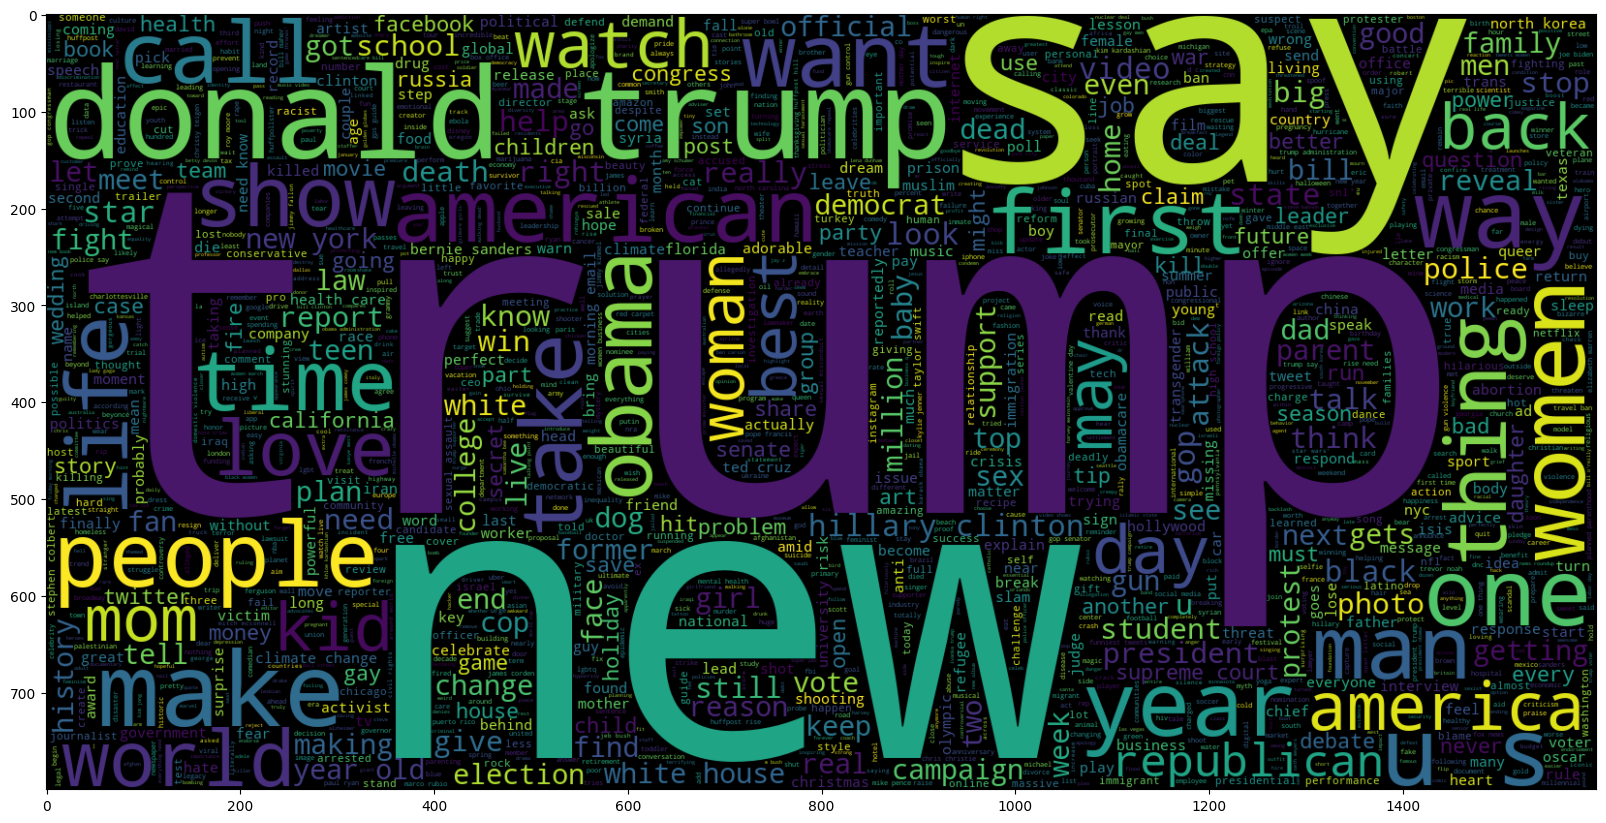

In [23]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].text))
plt.imshow(wc, interpolation='bilinear')

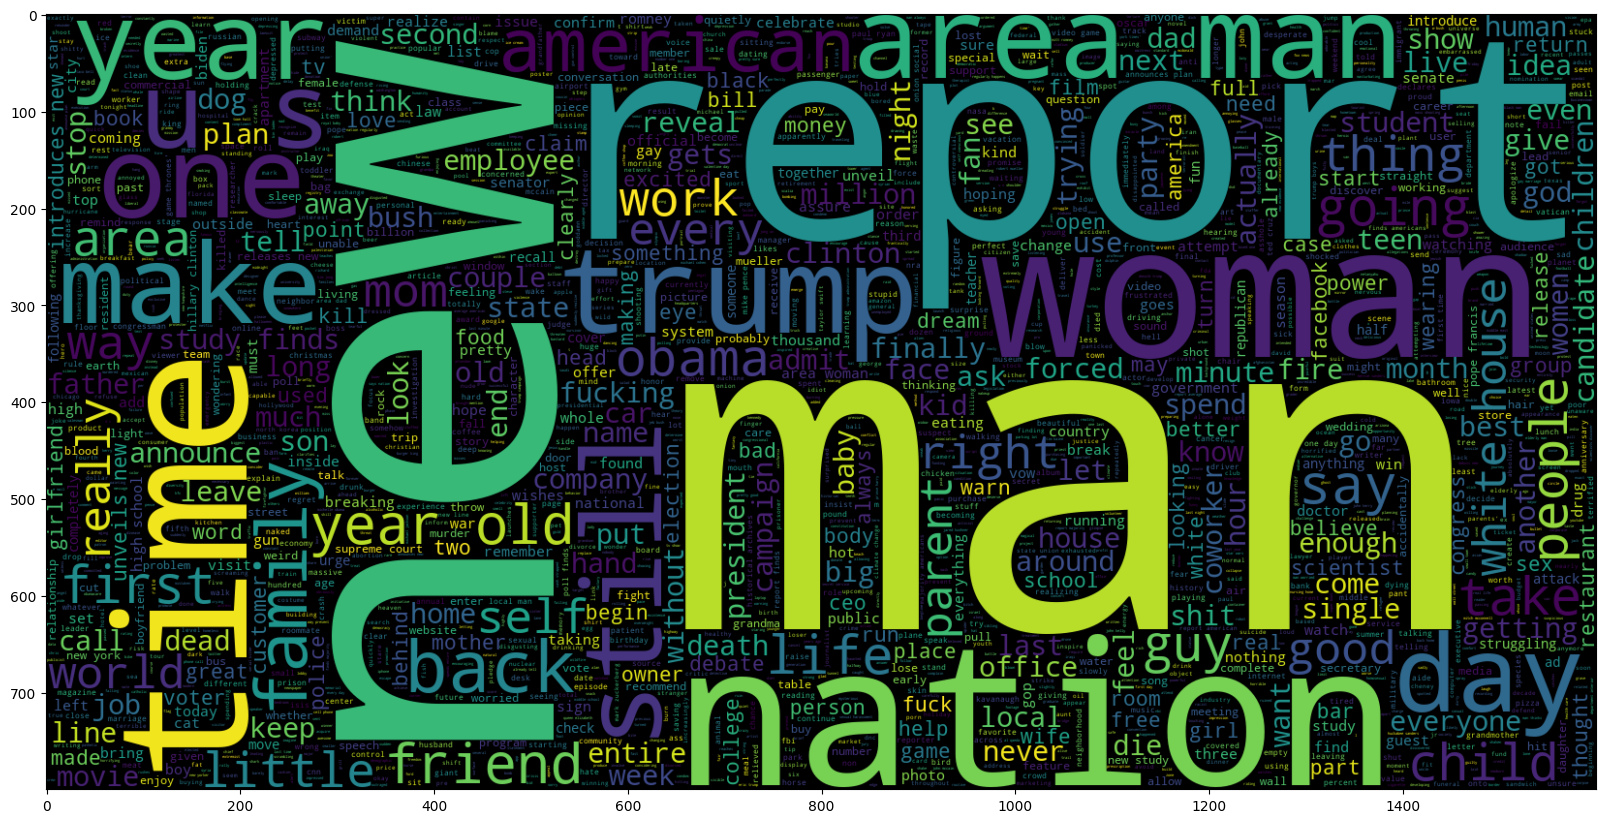

In [24]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

## Давайте обучим модель с помощью сервиса MLFlow

### Классический ML пайплайн

Обучим обычный TF-iDF векторайзер, а также градиентный бустинг

In [29]:
# Зададим переменные для MLFlow

EXPERIMENT_NAME = "churn_S2W2"
RUN_NAME = "model_sarcasm_classic"
REGISTRY_MODEL_NAME = "churn_model_sarcasm"

load_dotenv()
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_BUCKET_NAME"] = str(os.environ.get('S3_BUCKET_NAME'))
os.environ["AWS_ACCESS_KEY_ID"] = str(os.environ.get('AWS_ACCESS_KEY_ID'))
os.environ["AWS_SECRET_ACCESS_KEY"] = str(os.environ.get('AWS_SECRET_ACCESS_KEY'))
mlflow.set_tracking_uri(f"http://{os.environ.get('MLFLOW_SERVER_HOST')}:{os.environ.get('MLFLOW_SERVER_PORT')}")
mlflow.set_registry_uri(f"http://{os.environ.get('MLFLOW_SERVER_HOST')}:{os.environ.get('MLFLOW_SERVER_PORT')}")

if mlflow.get_experiment_by_name(name=EXPERIMENT_NAME):
    experiment_id = dict(mlflow.get_experiment_by_name(name=EXPERIMENT_NAME))['experiment_id']
else:
    mlflow.set_experiment(EXPERIMENT_NAME)
    experiment_id = dict(mlflow.get_experiment_by_name(name=EXPERIMENT_NAME))['experiment_id']

In [37]:
params = {
    'vect': {
        'ngram_range': (1, 2),
        'max_df': 0.95,
        'min_df': 2
    },
    'model': {
        
    }
}

### Вариант 1

In [52]:
# Preprocess data
import src.utils as utils
wc1, wc2 = utils.create_cloud(df)
mlflow.log_image(wc1.to_image(), "non_sarcastic_cloud.png")
mlflow.log_image(wc2.to_image(), "sarcastic_cloud.png")

vector = TfidfVectorizer(**params['vect'])
X = vector.fit_transform(df['text'])
# Split the data into training and test sets. (0.8, 0.20) split.
X_train, X_test,  y_train, y_test = train_test_split(X, df['is_sarcastic'], test_size=0.2)

pip_requirements="./requirements.txt" 
signature = mlflow.models.infer_signature(X_test, y_test)
input_example = X_test[:10]
metadata = {"model_type": "daily"}

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id, nested=True): # ['experiment_id']
    model = CatBoostClassifier(**params['model'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    _, err1, err2, _ = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    model_info = mlflow.catboost.log_model(
        cb_model=model,
        artifact_path="via_models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements,
        metadata=metadata,
    )

    mlflow.log_params(params=params)
    mlflow.log_metric("precision", precision[1])
    mlflow.log_metric("recall", recall[1])
    mlflow.log_metric("f_score", f_score[1])
    mlflow.log_metric("logloss", logloss)
    mlflow.log_metric("err1", err1)
    mlflow.log_metric("err2", err2)
    mlflow.log_metric("auc", auc)

Learning rate set to 0.039223
0:	learn: 0.6897420	total: 28.2ms	remaining: 28.1s
1:	learn: 0.6860406	total: 51.9ms	remaining: 25.9s
2:	learn: 0.6830664	total: 76.1ms	remaining: 25.3s
3:	learn: 0.6795324	total: 99.2ms	remaining: 24.7s
4:	learn: 0.6770753	total: 122ms	remaining: 24.2s
5:	learn: 0.6738245	total: 145ms	remaining: 23.9s
6:	learn: 0.6712945	total: 168ms	remaining: 23.8s
7:	learn: 0.6694490	total: 190ms	remaining: 23.6s
8:	learn: 0.6675900	total: 212ms	remaining: 23.4s
9:	learn: 0.6653944	total: 235ms	remaining: 23.3s
10:	learn: 0.6640695	total: 258ms	remaining: 23.2s
11:	learn: 0.6626766	total: 281ms	remaining: 23.1s
12:	learn: 0.6610127	total: 303ms	remaining: 23s
13:	learn: 0.6594716	total: 325ms	remaining: 22.9s
14:	learn: 0.6580113	total: 348ms	remaining: 22.9s
15:	learn: 0.6564589	total: 370ms	remaining: 22.7s
16:	learn: 0.6551891	total: 392ms	remaining: 22.7s
17:	learn: 0.6542180	total: 414ms	remaining: 22.6s
18:	learn: 0.6529770	total: 435ms	remaining: 22.5s
19:	learn

Registered model 'churn_model_sarcasm' already exists. Creating a new version of this model...
2024/06/30 22:30:30 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_sarcasm, version 3
Created version '3' of model 'churn_model_sarcasm'.


### Вариант 2

In [55]:
# Preprocess data
import src.utils as utils
wc1, wc2 = utils.create_cloud(df)
mlflow.log_image(wc1.to_image(), "non_sarcastic_cloud.png")
mlflow.log_image(wc2.to_image(), "sarcastic_cloud.png")

# vector = TfidfVectorizer(**params['vect'])
# X = vector.fit_transform(df['text'])
# Split the data into training and test sets. (0.8, 0.20) split.
X_train, X_test,  y_train, y_test = train_test_split(df.drop(columns='is_sarcastic'), df['is_sarcastic'], test_size=0.2)

pip_requirements="./requirements.txt" 
signature = mlflow.models.infer_signature(X_test, y_test)
input_example = X_test[:10]
metadata = {"model_type": "daily"}

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id, nested=True): # ['experiment_id']
    ct = ColumnTransformer([('vect', TfidfVectorizer(**params['vect']), 'text')])
    model = Pipeline(
        [
            ('transformer', ct),
            ('model', CatBoostClassifier(**params['model']))
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    _, err1, err2, _ = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="via_models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements,
        metadata=metadata,
    )

    mlflow.log_params(params=params)
    mlflow.log_metric("precision", precision[1])
    mlflow.log_metric("recall", recall[1])
    mlflow.log_metric("f_score", f_score[1])
    mlflow.log_metric("logloss", logloss)
    mlflow.log_metric("err1", err1)
    mlflow.log_metric("err2", err2)
    mlflow.log_metric("auc", auc)

Learning rate set to 0.039223
0:	learn: 0.6884137	total: 27.3ms	remaining: 27.3s
1:	learn: 0.6842413	total: 47.5ms	remaining: 23.7s
2:	learn: 0.6805790	total: 68.3ms	remaining: 22.7s
3:	learn: 0.6776647	total: 88ms	remaining: 21.9s
4:	learn: 0.6750444	total: 109ms	remaining: 21.8s
5:	learn: 0.6724197	total: 131ms	remaining: 21.7s
6:	learn: 0.6702649	total: 152ms	remaining: 21.5s
7:	learn: 0.6681533	total: 172ms	remaining: 21.3s
8:	learn: 0.6663311	total: 192ms	remaining: 21.2s
9:	learn: 0.6648326	total: 212ms	remaining: 21s
10:	learn: 0.6629750	total: 232ms	remaining: 20.9s
11:	learn: 0.6607651	total: 252ms	remaining: 20.8s
12:	learn: 0.6589057	total: 272ms	remaining: 20.7s
13:	learn: 0.6576364	total: 293ms	remaining: 20.6s
14:	learn: 0.6558447	total: 313ms	remaining: 20.5s
15:	learn: 0.6543434	total: 336ms	remaining: 20.6s
16:	learn: 0.6530848	total: 356ms	remaining: 20.6s
17:	learn: 0.6519006	total: 376ms	remaining: 20.5s
18:	learn: 0.6508358	total: 396ms	remaining: 20.4s
19:	learn: 

AttributeError: 'Pipeline' object has no attribute 'save_model'